In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools

from functools import reduce

spm = pd.read_csv('SPM/SPM_results.csv', sep=',')
scc_col = pd.read_csv('SCC/SCC_COL_results.csv', sep=',')
scc_fb = pd.read_csv('SCC/SCC_FB_results.csv', sep=',')
sorting = pd.read_csv('sorting/sorting_results.csv', sep=',')
prefix_sum = pd.read_csv('prefix_sum/prefix_sum_results.csv', sep=',')
synthesis = pd.read_csv('synthesis/synthesis_results.csv', sep=',')

all_data = [spm, scc_col, scc_fb, sorting, prefix_sum, synthesis];
cols = list(map((lambda d : d.columns), all_data));
assert (all([all(cols[i-1] == cols[i]) for i in range(1, len(cols))]));

data = pd.concat(all_data, ignore_index=True);

data


,memorder,schedule,voting-strat,weak_non_racing,algorithm,problem_type,problem_size,runtime
0,seqcons,on-host,on-host-simple,1,SPM,Invariantly Inevitably Eat,794,24.609709
1,seqcons,on-host,on-host-simple,1,SPM,Invariantly Inevitably Eat,2964,79.0882
2,seqcons,on-host,on-host-simple,1,SPM,Invariantly Inevitably Eat,11014,255.01859
3,seqcons,on-host,on-host-simple,1,SPM,Invariantly Inevitably Eat,40677,839.9227
4,seqcons,on-host,on-host-simple,1,SPM,Invariantly Inevitably Eat,149262,3226.2004
...,...,...,...,...,...,...,...,...
1073,relaxed,on-host,on-host-alternating,1,synthesis,Random,229856,1.420662
1074,relaxed,on-host,on-host-alternating,1,synthesis,Random,1263755,4.043728
1075,relaxed,on-host,on-host-alternating,1,synthesis,Random,2298699,10.142061
1076,relaxed,on-host,on-host-alternating,1,synthesis,Random,12653328,138.00208


In [2]:
data = data.drop(data[data["runtime"] == "timeout"].index);
data["runtime"] = data["runtime"].astype(float);
data["problem_size"] = data["problem_size"].astype(int);
data["weak_non_racing"] = data["weak_non_racing"].astype(bool);

#data[data["algorithm"] == "SCC_COL"]["runtime"].unique()

In [3]:
""" Returns all rows with a configuration that is present
    for all possible values of variable_parameter, such that
    the only configuration-related difference between rows 
    is the variable_parameter.
"""
def get_comparable_rows(all_rows, rows, variable_parameter):
    # Group rows by config, except for the variable_parameter
    config_cols = [
        "memorder",
        "schedule",
        "voting-strat",
        "weak_non_racing",
        "algorithm",
        "problem_type",
        "problem_size"
    ];
    config_cols.remove(variable_parameter);
    
    # Compute all available variable_parameter options
    p_options = all_rows[variable_parameter].unique();
    
    # Per possible value of variable_parameter, get the corresponding rows
    rows_per_option = [rows[rows[variable_parameter] == opt] for opt in p_options];
    
    # Find the unique configs present per value of variable_parameter
    sets_of_configs = [set(r.groupby(config_cols).groups.keys()) for r in rows_per_option];
    
    # Get configs which are present for all possible values of variable_parameter
    shared_configs = list(reduce((lambda x, y : x & y), sets_of_configs));
    
    # Return all rows which have a shared config
    by_config = rows.groupby(config_cols);
    comp_rows = [];
    for (c, c_rows) in by_config:
        if c in shared_configs:
            comp_rows.append(c_rows);
    if comp_rows == []:
        print("WARNING: EMPTY ROWS TO COMPARE");
        return pd.DataFrame(data={});
    comparable_rows = pd.concat(comp_rows);
        
    return comparable_rows;


In [4]:
def bar_chart(all_rows, rows, title, variable_parameter, ordering=None, yscale="log", xlabel="Problem size", xscale="linear"):
    if ordering == None:
        ordering = all_rows[variable_parameter].unique();
    assert (len(ordering) == len(all_rows[variable_parameter].unique()))
    
    plt.figure();
    plt.title(title);
    rows = get_comparable_rows(all_rows, rows, variable_parameter);
    tot_width = 0.8;
    width = tot_width / len(ordering);
    offset = - 0.5 * tot_width + 0.5 * width;
    
    ys = [];
    p_sizes = list(rows["problem_size"].unique());
    p_sizes.sort();
    nrof_values = len(p_sizes);
    
    for o, rows in [(o, rows[rows[variable_parameter] == o]) for o in ordering]:
        Y = rows.groupby("problem_size")["runtime"].mean();
        assert(nrof_values == len(Y.values));
        X = [x + offset for x in range(len(Y.values))];
        ys.append(Y);
        plt.bar(X, Y.values, width=width, label=o);
        offset += width;
    plt.xlabel(xlabel);
    plt.xscale(xscale);
    plt.xticks(range(nrof_values), [str(round(p, -3)/1000)+"K" for p in p_sizes]);
    plt.yscale(yscale);
    plt.ylabel("runtime (ms)");
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");
    plt.show();
    return ys;

def scatter_chart(all_rows, rows, title, variable_parameter, ordering=None, yscale="log", xlabel="Problem size", xscale="linear"):
    if ordering == None:
        ordering = all_rows[variable_parameter].unique();
    assert (len(ordering) == len(all_rows[variable_parameter].unique()))
    
    plt.figure();
    plt.title(title);
    rows = get_comparable_rows(all_rows, rows, variable_parameter);
    cols = ["C0", "C1", "C2", "C3", "C4", "C5"];
    col_idx = 0;
    for o, rows in [(o, rows[rows[variable_parameter] == o]) for o in ordering]:
        for c, rows in rows.groupby("config"):
            plt.plot(rows["problem_size"], rows["runtime"], color=cols[col_idx % len(cols)], label=o);
        col_idx += 1;
    
    plt.xlabel(xlabel);
    plt.xscale(xscale);
    plt.yscale(yscale);
    plt.ylabel("runtime (ms)");
    patches = [mpatches.Patch(color=cols[i % len(cols)], label=ordering[i]) for i in range(len(ordering))];
    plt.legend(handles=patches, bbox_to_anchor=(1.04, 1), loc="upper left");
    plt.show();

Skipping ('graph', 'graph-shared', True)
Skipping ('graph', 'graph-shared-banks', True)
Skipping ('in-kernel', 'in-kernel-alternating', True)
Skipping ('on-host', 'on-host-alternating', True)


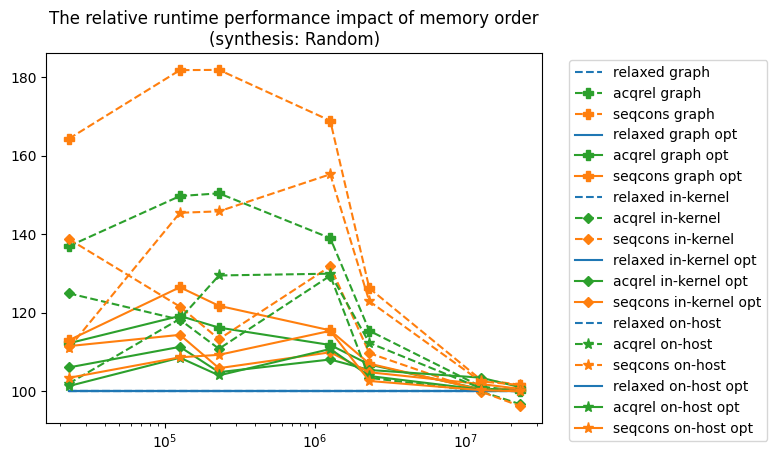

Skipping ('graph', 'graph-shared', True)
Skipping ('graph', 'graph-shared-banks', True)
Skipping ('in-kernel', 'in-kernel-alternating', True)
Skipping ('on-host', 'on-host-alternating', True)


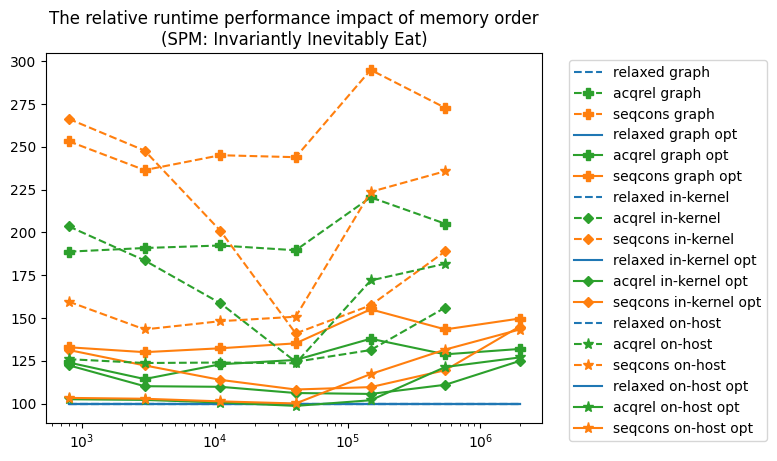

Skipping ('graph', 'graph-shared', True)
Skipping ('graph', 'graph-shared-banks', True)
Skipping ('in-kernel', 'in-kernel-alternating', True)
Skipping ('on-host', 'on-host-alternating', True)


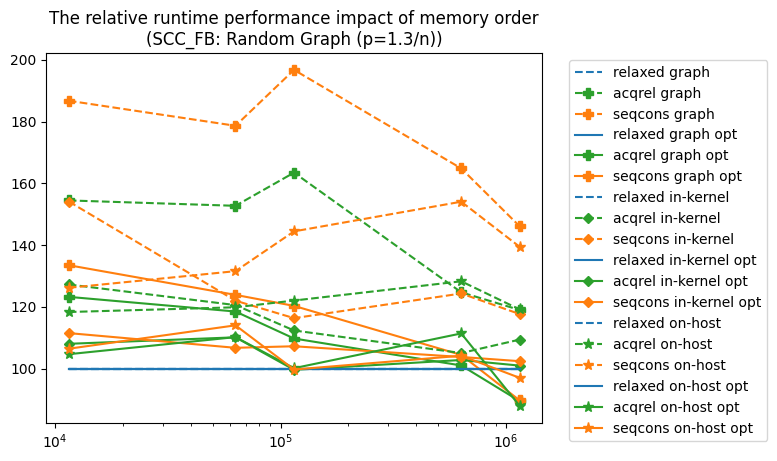

Skipping ('graph', 'graph-shared', True)
Skipping ('graph', 'graph-shared-banks', True)
Skipping ('in-kernel', 'in-kernel-alternating', True)
Skipping ('on-host', 'on-host-alternating', True)


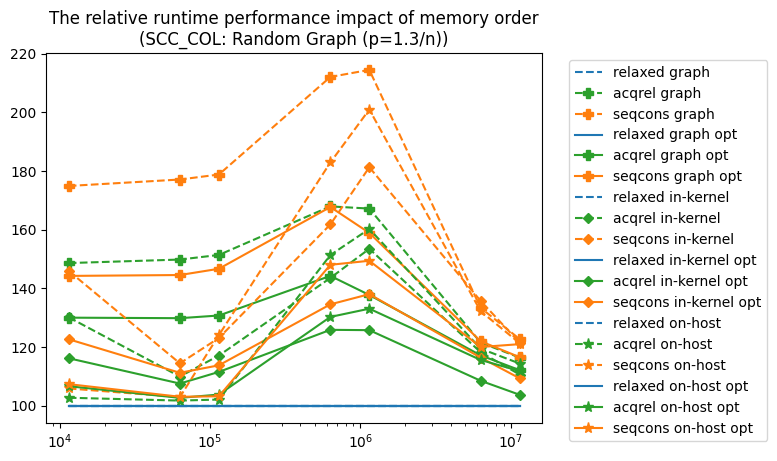

In [5]:
def memorder_chart(alg, p_type, data):
    rows = data[(data["algorithm"] == alg) & (data["problem_type"] == p_type)];
    plt.figure();
    plt.title(f"The relative runtime performance impact of memory order\n({alg}: {p_type})");
    order = ["relaxed", "acqrel", "seqcons"];
    
    colors = {
        "relaxed": "C0",
        "acqrel": "C2",
        "seqcons": "C1"
    };
    linestyles = {
        True: "-",
        False: "--"
    };
    markers = {
        "graph": ("P", 7),
        "in-kernel": ("D", 5),
        "on-host": ("*", 8)
    };
    
    config_cols = [
        "schedule",
        "voting-strat",
        "weak_non_racing",
    ];
    for c, c_rows in rows.groupby(config_cols):
        if len(c_rows["memorder"].unique()) != 3:
            print(f"Skipping {c}");
            continue;
        
        o_data = [
            c_rows[c_rows["memorder"] == o]
            [["problem_size", "runtime"]]
            .set_index("problem_size")
            .rename(columns={"runtime": f"runtime_{o}"})
            for o in order
        ];
        ref = pd.concat(o_data, axis=1);
        
        for o in order:
            plt.plot(
                ref.index,
                (ref[f"runtime_{o}"] / ref[f"runtime_relaxed"]) * 100,
                color=colors[o],
                label=f"{o} {c[0]}{' opt' if c[2] else ''}",
                linestyle=linestyles[c[2]],
                marker=markers[c[0]][0] if o != "relaxed" else None,
                markersize=markers[c[0]][1]
            );
            
    plt.xscale("log");
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");
    plt.show();

memorder_chart("synthesis", "Random", data)
memorder_chart("SPM", "Invariantly Inevitably Eat", data)
memorder_chart("SCC_FB", "Random Graph (p=1.3/n)", data)
memorder_chart("SCC_COL", "Random Graph (p=1.3/n)", data)

Skipping ('graph', 'graph-shared', True)
Skipping ('graph', 'graph-shared-banks', True)
Skipping ('in-kernel', 'in-kernel-alternating', True)
Skipping ('on-host', 'on-host-alternating', True)


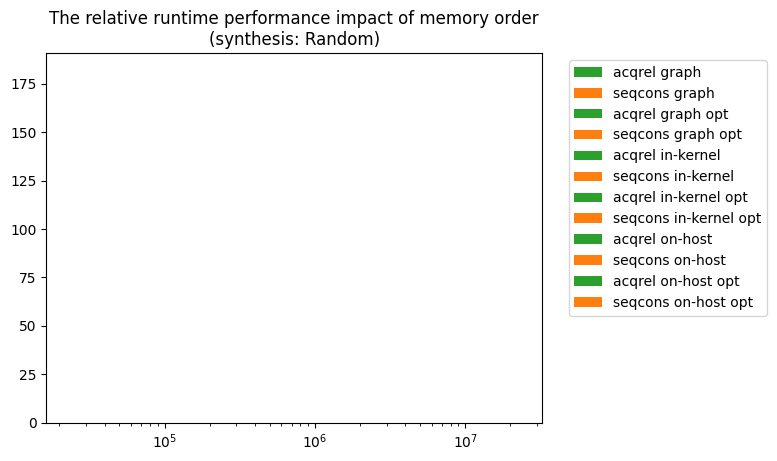

In [6]:
def memorder_chart2(alg, p_type, data):
    rows = data[(data["algorithm"] == alg) & (data["problem_type"] == p_type)];
    plt.figure();
    plt.title(f"The relative runtime performance impact of memory order\n({alg}: {p_type})");
    order = ["relaxed", "acqrel", "seqcons"];
    
    colors = {
        "relaxed": "C0",
        "acqrel": "C2",
        "seqcons": "C1"
    };
    linestyles = {
        True: "-",
        False: "--"
    };
    markers = {
        "graph": ("P", 7),
        "in-kernel": ("D", 5),
        "on-host": ("*", 8)
    };
    
    config_cols = [
        "schedule",
        "voting-strat",
        "weak_non_racing",
    ];
    for c, c_rows in rows.groupby(config_cols):
        if len(c_rows["memorder"].unique()) != 3:
            print(f"Skipping {c}");
            continue;
        
        o_data = [
            c_rows[c_rows["memorder"] == o]
            [["problem_size", "runtime"]]
            .set_index("problem_size")
            .rename(columns={"runtime": f"runtime_{o}"})
            for o in order
        ];
        ref = pd.concat(o_data, axis=1);
        
        for o in order[1:]:
            plt.bar(
                ref.index,
                (ref[f"runtime_{o}"] / ref[f"runtime_relaxed"]) * 100,
                color=colors[o],
                label=f"{o} {c[0]}{' opt' if c[2] else ''}"
            );
            
    plt.xscale("log");
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");
    plt.show();

memorder_chart2("synthesis", "Random", data)

In [7]:
rlx = rows[rows["memorder"] == "relaxed"][["problem_size", "runtime"]];
rlx = rlx.set_index("problem_size");
rlx = rlx.rename(columns={"runtime": "runtime_rlx"});
acqrel = rows[rows["memorder"] == "acqrel"][["problem_size", "runtime"]];
acqrel = acqrel.set_index("problem_size");
acqrel = acqrel.rename(columns={"runtime": "runtime_acqrel"});
seqcons = rows[rows["memorder"] == "seqcons"][["problem_size", "runtime"]];
seqcons = seqcons.set_index("problem_size");
seqcons = seqcons.rename(columns={"runtime": "runtime_seqcons"});

pd.concat([rlx, acqrel, seqcons], axis=1)

NameError: name 'rows' is not defined

In [ ]:
config_parameters = [
    ("memorder", ["relaxed", "acqrel", "seqcons"]),
    ("voting-strat", ["naive-alternating", "naive"]),
    ("weak_read_only", [1, 0]),
    ("division_strat", ["gridsize", "blocksize"])
];
    
multi_indices = [
    pd.MultiIndex.from_tuples(
        [("", "algorithm"), ("", "problem_type"), ("", "problem_size")]
    )
];
for (c, opts) in config_parameters:
    multi_indices.append(
        pd.MultiIndex.from_product(
            [
                [c],
                opts + ["#configs"]
            ],
            names=['optimisation technique', 'variant']
        )
    )

table_columns = reduce(lambda x, y : x.append(y), multi_indices);

table_data = [];
runtime_cols = [];
config_cols = [];
cols_done = False;
for alg, alg_rows in data.groupby("algorithm"):
    for p_type, p_type_rows in alg_rows.groupby("problem_type"):
        for p_size, p_size_rows in p_type_rows.groupby("problem_size"):
            current_row = [alg, p_type, p_size];
            for (c, opts) in config_parameters:
                if not cols_done:
                    runtime_cols += list(range(len(current_row), len(current_row)+len(opts)));
                    config_cols += [len(current_row)+len(opts)];
                rows = get_comparable_rows(data, p_size_rows, c);
                nrof_comp_rows = len(rows.index);
                if nrof_comp_rows == 0:
                    current_row += ["-"] * len(opts);
                else:
                    mean_runtimes = [rows[rows[c] == o]["runtime"].mean() for o in opts];
                    relative_runtimes = [mean_runtimes[i]/mean_runtimes[0] for i in range(len(mean_runtimes))];
                    as_percentage = ["{0:.0%}".format((f-1)) for f in relative_runtimes];
                    current_row += as_percentage;
                current_row += [int(nrof_comp_rows/len(opts))];
            table_data.append(current_row);
            cols_done = True;
runtime_cols = [table_columns[i] for i in runtime_cols];
config_cols = [table_columns[i] for i in config_cols];

table = pd.DataFrame(data=table_data, columns = table_columns);


In [ ]:
def color_performance(val):
    if val == "0%":
        color = "black";
    elif val.startswith("-"):
        color = "green";
    else:
        color = "red";

    return 'color: {}'.format(color)

def border(val):
    return 'border-right: 1px solid black';

styled_table = table.style.applymap(color_performance, 
                  subset=runtime_cols).applymap(border, subset= [("", "problem_size")] + config_cols);

styled_table.to_excel(r'results_table.xlsx', index=True)
